#loading data set

In [69]:
# Importing necessary libraries for the notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from statsmodels.tsa.arima.model import ARIMA

# Ensuring display settings are optimized for output
pd.set_option('display.max_columns', None)

In [70]:
covid19_clean = pd.read_csv(r'C:\Users\DELL\Downloads\covid_19_clean_complete.csv')
full_grouped  = pd.read_csv(r'C:\Users\DELL\Downloads\full_grouped.csv')
day_wise = pd.read_csv(r'C:\Users\DELL\Downloads\day_wise.csv')
country_wise = pd.read_csv(r'C:\Users\DELL\Downloads\country_wise_latest.csv')
worldometer = pd.read_csv(r'C:\Users\DELL\Downloads\worldometer_data.csv')

In [105]:
# Data Preprocessing: Handle missing values and ensure clean datasets

# Converting 'Date' to datetime format
if 'Date' in covid19_clean.columns:
    covid19_clean['Date'] = pd.to_datetime(covid19_clean['Date'], errors='coerce')

# Fill missing numeric values with 0 where appropriate
covid19_clean.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)

# Derive new features
covid19_clean['Mortality Rate'] = (covid19_clean['Deaths'] / covid19_clean['Confirmed']) * 100
covid19_clean['Cases per 100k Population'] = (covid19_clean['Confirmed'] / 1_000_000) * 100_000
covid19_clean['Daily Growth Rate'] = covid19_clean['Confirmed'].pct_change().fillna(0)

In [72]:
print(covid19_clean.head())

  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN        Albania  41.15330  20.168300 2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600 2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800 2020-01-22          0   
4            NaN         Angola -11.20270  17.873900 2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  Mortality Rate  \
0       0          0       0  Eastern Mediterranean             NaN   
1       0          0       0                 Europe             NaN   
2       0          0       0                 Africa             NaN   
3       0          0       0                 Europe             NaN   
4       0          0       0                 Africa             NaN   

   Cases per 100k Population  Daily Growth Rate  
0                        0.0                0.0  
1   

In [73]:
print(worldometer.head())

  Country/Region      Continent    Population  TotalCases  NewCases  \
0            USA  North America  3.311981e+08     5032179       NaN   
1         Brazil  South America  2.127107e+08     2917562       NaN   
2          India           Asia  1.381345e+09     2025409       NaN   
3         Russia         Europe  1.459409e+08      871894       NaN   
4   South Africa         Africa  5.938157e+07      538184       NaN   

   TotalDeaths  NewDeaths  TotalRecovered  NewRecovered  ActiveCases  \
0     162804.0        NaN       2576668.0           NaN    2292707.0   
1      98644.0        NaN       2047660.0           NaN     771258.0   
2      41638.0        NaN       1377384.0           NaN     606387.0   
3      14606.0        NaN        676357.0           NaN     180931.0   
4       9604.0        NaN        387316.0           NaN     141264.0   

   Serious,Critical  Tot Cases/1M pop  Deaths/1M pop  TotalTests  \
0           18296.0           15194.0          492.0  63139605.0   
1   

In [74]:
print(full_grouped.head())

         Date Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
0  2020-01-22    Afghanistan          0       0          0       0          0   
1  2020-01-22        Albania          0       0          0       0          0   
2  2020-01-22        Algeria          0       0          0       0          0   
3  2020-01-22        Andorra          0       0          0       0          0   
4  2020-01-22         Angola          0       0          0       0          0   

   New deaths  New recovered             WHO Region  
0           0              0  Eastern Mediterranean  
1           0              0                 Europe  
2           0              0                 Africa  
3           0              0                 Europe  
4           0              0                 Africa  


In [75]:
print(day_wise.head())

         Date  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \
0  2020-01-22        555      17         28     510          0           0   
1  2020-01-23        654      18         30     606         99           1   
2  2020-01-24        941      26         36     879        287           8   
3  2020-01-25       1434      42         39    1353        493          16   
4  2020-01-26       2118      56         52    2010        684          14   

   New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0              0                3.06                   5.05   
1              2                2.75                   4.59   
2              6                2.76                   3.83   
3              3                2.93                   2.72   
4             13                2.64                   2.46   

   Deaths / 100 Recovered  No. of countries  
0                   60.71                 6  
1                   60.00                 8  
2             

In [101]:
print(country_wise.head())

  Country/Region  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \
0    Afghanistan      36263    1269      25198    9796        106          10   
1        Albania       4880     144       2745    1991        117           6   
2        Algeria      27973    1163      18837    7973        616           8   
3        Andorra        907      52        803      52         10           0   
4         Angola        950      41        242     667         18           1   

   New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0             18                3.50                  69.49   
1             63                2.95                  56.25   
2            749                4.16                  67.34   
3              0                5.73                  88.53   
4              0                4.32                  25.47   

   Deaths / 100 Recovered  Confirmed last week  1 week change  \
0                    5.04                35526            737   
1   

In [107]:
# Inspect column names
print(covid19_clean.columns)
print(worldometer.columns)

# Merge `covid19_clean` with `worldometer` on 'Country/Region'
covid19_clean = covid19_clean.merge(
    worldometer[['Country/Region', 'Population']], 
    left_on='Country/Region', 
    right_on='Country/Region', 
    how='left'
)

# Check the merged dataset to ensure it worked correctly
print(covid19_clean.head())

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region', 'Mortality Rate',
       'Cases per 100k Population', 'Daily Growth Rate'],
      dtype='object')
Index(['Country/Region', 'Continent', 'Population', 'TotalCases', 'NewCases',
       'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered',
       'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop',
       'TotalTests', 'Tests/1M pop', 'WHO Region'],
      dtype='object')
  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN        Albania  41.15330  20.168300 2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600 2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800 2020-01-22          0   
4            NaN         Angola -11.20270  17.873900 2020-01-22          0   



In [115]:

# 1. Check and handle missing values
# Drop rows where 'Country/Region' or 'Date' are missing, as they are critical
covid19_clean.dropna(subset=['Country/Region', 'Date'], inplace=True)

# Fill missing numeric values with 0 (or another appropriate value based on the dataset context)
numeric_columns = ['Confirmed', 'Deaths', 'Recovered', 'Active', 
                   'Mortality Rate', 'Cases per 100k Population', 'Daily Growth Rate', 'Population']
covid19_clean[numeric_columns] = covid19_clean[numeric_columns].fillna(0)

# Fill missing 'Province/State' with 'Unknown' if needed
covid19_clean['Province/State'] = covid19_clean['Province/State'].fillna('Unknown')

# 2. Ensure correct data types
# Convert numeric columns to appropriate types
covid19_clean[numeric_columns] = covid19_clean[numeric_columns].apply(pd.to_numeric)

# 3. Remove unnecessary columns
# Example: Drop columns if deemed redundant
columns_to_drop = ['Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']
covid19_clean.drop(columns=[col for col in columns_to_drop if col in covid19_clean.columns], axis=1, inplace=True)

# 4. Handle outliers
# Optional: Define thresholds for valid ranges (e.g., no negative values)
for col in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid19_clean[col] =covid19_clean[col].clip(lower=0)

# 5. Standardize column names
covid19_clean.columns = covid19_clean.columns.str.replace(' ', '_').str.lower()

# 6. Sort and reindex data
covid19_clean.sort_values(by=['country/region', 'date'], inplace=True)
covid19_clean.reset_index(drop=True, inplace=True)

# Save the cleaned data to a new CSV file
covid19_clean.to_csv('cleaned_data.csv', index=False)

print("Data cleaning complete. Cleaned data saved to 'cleaned_data.csv'.")


Data cleaning complete. Cleaned data saved to 'cleaned_data.csv'.


In [119]:
print(covid19_clean)

      province/state country/region        lat       long       date  \
0            Unknown    Afghanistan  33.939110  67.709953 2020-01-22   
1            Unknown    Afghanistan  33.939110  67.709953 2020-01-23   
2            Unknown    Afghanistan  33.939110  67.709953 2020-01-24   
3            Unknown    Afghanistan  33.939110  67.709953 2020-01-25   
4            Unknown    Afghanistan  33.939110  67.709953 2020-01-26   
...              ...            ...        ...        ...        ...   
49063        Unknown       Zimbabwe -19.015438  29.154857 2020-07-23   
49064        Unknown       Zimbabwe -19.015438  29.154857 2020-07-24   
49065        Unknown       Zimbabwe -19.015438  29.154857 2020-07-25   
49066        Unknown       Zimbabwe -19.015438  29.154857 2020-07-26   
49067        Unknown       Zimbabwe -19.015438  29.154857 2020-07-27   

       confirmed  deaths  recovered  active             who_region  \
0              0       0          0       0  Eastern Mediterranea

C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\4007279505.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='who_region', y='mortality_rate', data=covid19_clean, palette='viridis')


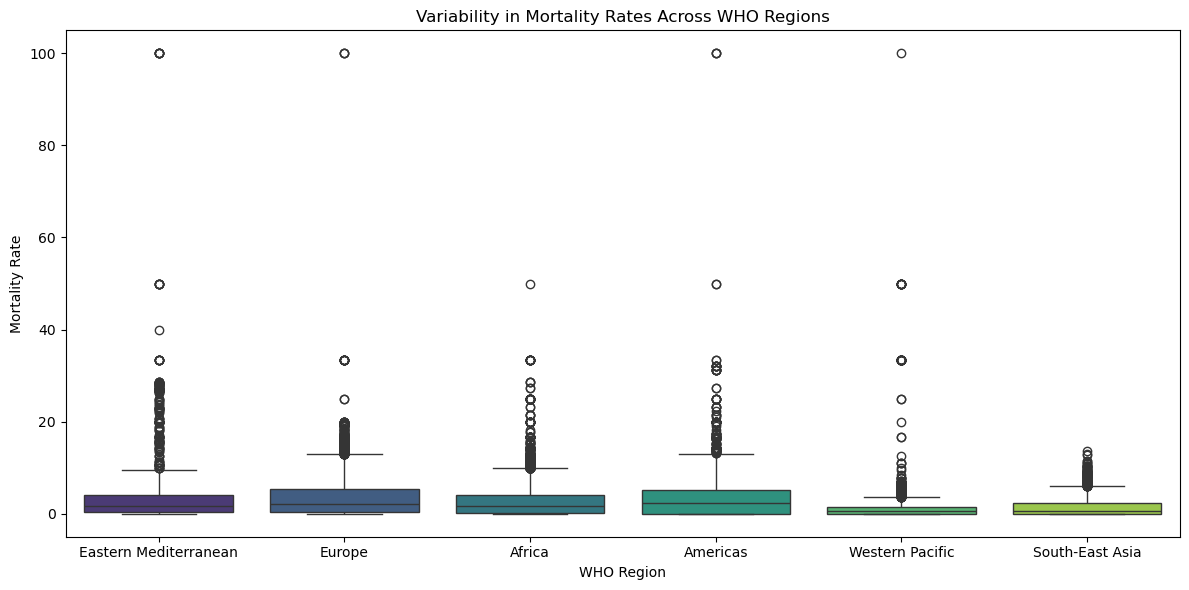

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'covid19_clean' is the dataset and 'mortality_rate' is the column containing mortality rates,
# and 'who_region' contains the region information

plt.figure(figsize=(12, 6))

# Create a boxplot showing mortality rate distribution across different WHO regions
sns.boxplot(x='who_region', y='mortality_rate', data=covid19_clean, palette='viridis')

# Set plot title and labels
plt.title('Variability in Mortality Rates Across WHO Regions')
plt.xlabel('WHO Region')
plt.ylabel('Mortality Rate')

# Display the plot
plt.tight_layout()
plt.show()


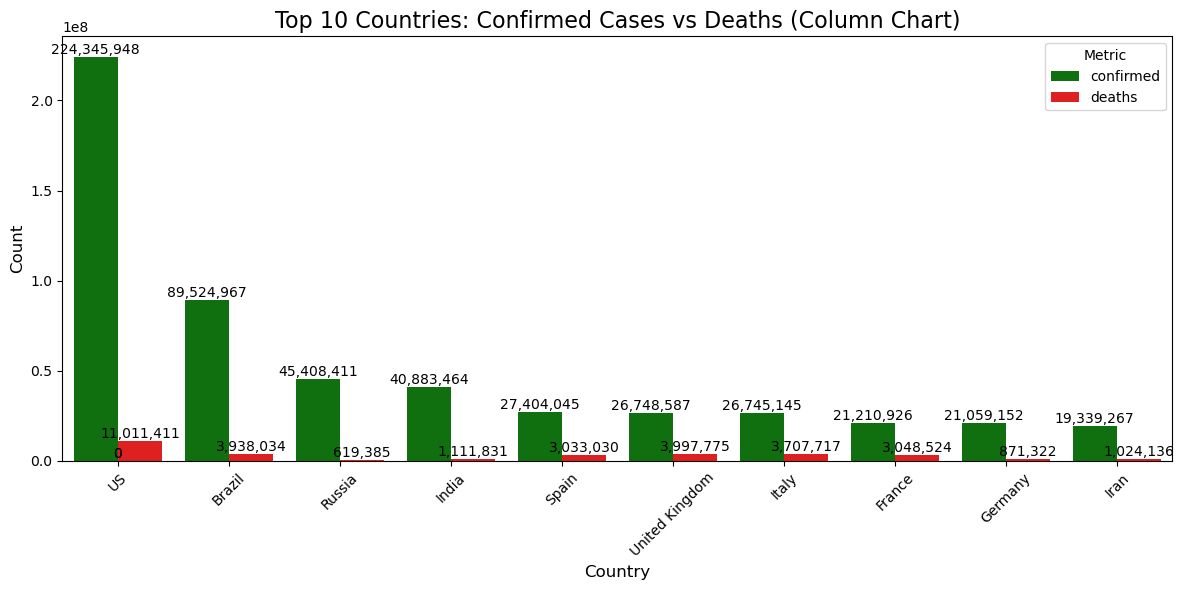

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Melt the data for a grouped column chart
top_countries_melted = top_countries.melt(
    id_vars=['country/region'], 
    value_vars=['confirmed', 'deaths'], 
    var_name='metric', 
    value_name='count'
)

# Plot the grouped column chart using sns.barplot (vertical bars by default)
sns.barplot(
    data=top_countries_melted, 
    x='country/region',  # Category axis (vertical columns)
    y='count',           # Value axis
    hue='metric',        # Group by metric
    palette={'confirmed': 'green', 'deaths': 'red'}, 
    ax=ax
)

# Add annotations for each column
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_height()):,}',  # Format as thousands
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Set title and labels
ax.set_title('Top 10 Countries: Confirmed Cases vs Deaths (Column Chart)', fontsize=16)
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjust legend position
ax.legend(title='Metric', loc='upper right', fontsize=10)

# Save the plot and show it
plt.tight_layout()  # Ensures everything fits within the plot area
plt.savefig("Top_10_Countries_Confirmed_vs_Deaths_Column_Chart.png", dpi=300)  # Save for report
plt.show()



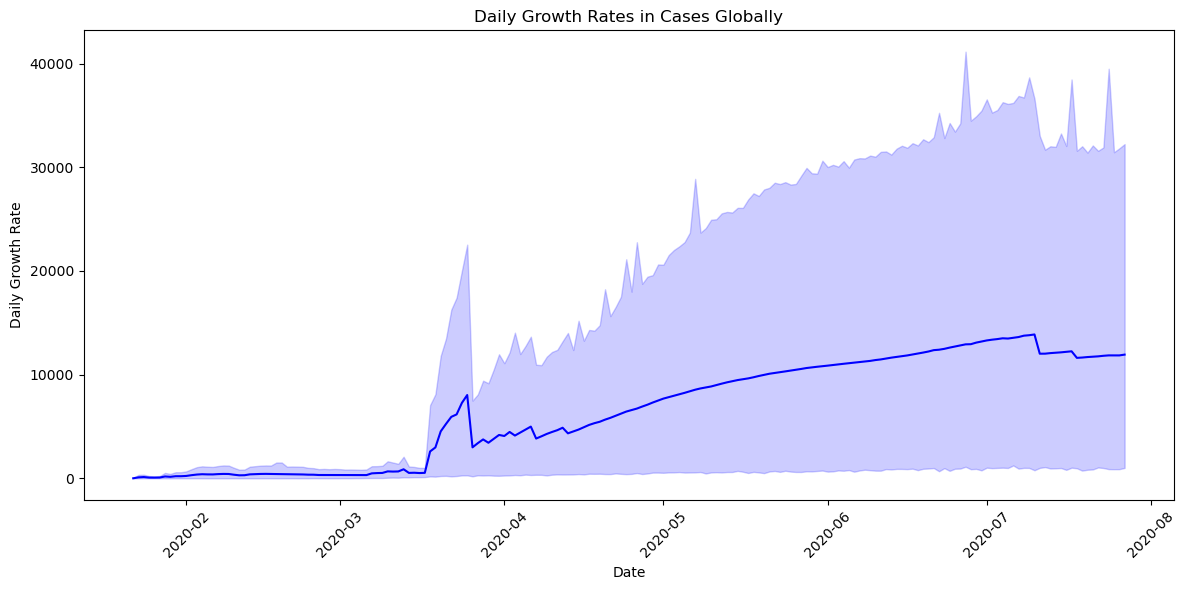

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'covid19_clean' is the dataset and 'date' and 'daily_growth_rate' are the relevant columns

# Convert 'date' to datetime format if it's not already in datetime format
covid19_clean['date'] = pd.to_datetime(covid19_clean['date'], errors='coerce')

# Plotting the daily growth rate globally over time
plt.figure(figsize=(12, 6))

# Create a line plot for daily growth rate
sns.lineplot(x='date', y='daily_growth_rate', data=covid19_clean, color='blue')

# Set plot title and labels
plt.title('Daily Growth Rates in Cases Globally')
plt.xlabel('Date')
plt.ylabel('Daily Growth Rate')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [131]:
print(covid19_clean.columns)


Index(['province/state', 'country/region', 'lat', 'long', 'date', 'confirmed',
       'deaths', 'recovered', 'active', 'who_region', 'mortality_rate',
       'cases_per_100k_population', 'daily_growth_rate', 'population'],
      dtype='object')


In [145]:
# Sort by region and date to calculate growth rates correctly
covid19_clean.sort_values(['country/region', 'date'], inplace=True)

# Calculate the daily growth rate
covid19_clean['daily_growth_rate'] = covid19_clean.groupby('country/region')['confirmed'].pct_change() * 100

# Replace infinite or NaN growth rates with 0 (e.g., for the first date or zero cases)
covid19_clean['daily_growth_rate'].fillna(0, inplace=True)
covid19_clean['daily_growth_rate'] = covid19_clean['daily_growth_rate'].replace([float('inf'), -float('inf')], 0)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\2772471512.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  covid19_clean['daily_growth_rate'].fillna(0, inplace=True)


In [147]:
# Correct way to fill NaN values without using inplace=True
covid19_clean['daily_growth_rate'] = covid19_clean['daily_growth_rate'].fillna(0)

# Correct way to replace infinite values
covid19_clean['daily_growth_rate'] = covid19_clean['daily_growth_rate'].replace([float('inf'), -float('inf')], 0)


In [149]:
# Calculate the mortality ratio
covid19_clean['mortality_ratio'] = (covid19_clean['deaths'] / covid19_clean['confirmed']) * 100

# Replace NaN or infinite values with 0 (e.g., where confirmed cases are 0)
covid19_clean['mortality_ratio'].fillna(0, inplace=True)
covid19_clean['mortality_ratio'] = covid19_clean['mortality_ratio'].replace([float('inf'), -float('inf')], 0)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\1527952969.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  covid19_clean['mortality_ratio'].fillna(0, inplace=True)


In [151]:
covid19_clean['mortality_ratio'] = covid19_clean['mortality_ratio'].fillna(0)


In [155]:
# Calculate cases per 100k population
covid19_clean['cases_per_100k'] = (covid19_clean['confirmed'] / covid19_clean['population']) * 100000

# Replace NaN or infinite values with 0 (e.g., where population is 0)
covid19_clean['cases_per_100k'].fillna(0, inplace=True)
covid19_clean['cases_per_100k'] = covid19_clean['cases_per_100k'].replace([float('inf'), -float('inf')], 0)


C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\3629256708.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  covid19_clean['cases_per_100k'].fillna(0, inplace=True)


In [157]:
covid19_clean['cases_per_100k'] = covid19_clean['cases_per_100k'].fillna(0)


In [217]:
# View the first few rows of the dataset
print(covid19_clean.head())

# Check the shape of the dataset (rows and columns)
print(covid19_clean.shape)

# Check data types of columns
print(covid19_clean.dtypes)

# Get general statistics (mean, median, min, max, etc.)
print(covid19_clean.describe())

# Check for missing values
print(covid19_clean.isnull().sum())

# Check for unique values in each column (useful for categorical data)
print(covid19_clean.nunique())


  province/state country/region       lat       long       date  confirmed  \
0        Unknown    Afghanistan  33.93911  67.709953 2020-01-22          0   
1        Unknown    Afghanistan  33.93911  67.709953 2020-01-23          0   
2        Unknown    Afghanistan  33.93911  67.709953 2020-01-24          0   
3        Unknown    Afghanistan  33.93911  67.709953 2020-01-25          0   
4        Unknown    Afghanistan  33.93911  67.709953 2020-01-26          0   

   deaths  recovered  active             who_region mortality_rate  \
0       0          0       0  Eastern Mediterranean           <NA>   
1       0          0       0  Eastern Mediterranean           <NA>   
2       0          0       0  Eastern Mediterranean           <NA>   
3       0          0       0  Eastern Mediterranean           <NA>   
4       0          0       0  Eastern Mediterranean           <NA>   

   cases_per_100k_population  daily_growth_rate  population  mortality_ratio  \
0                        0.0  

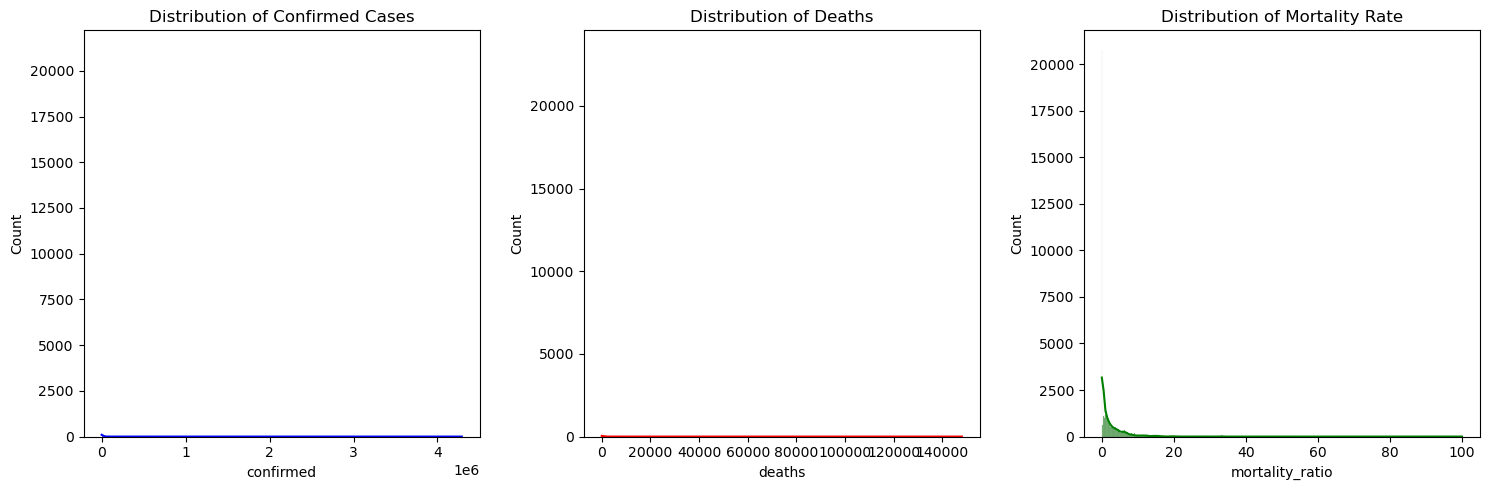

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of 'confirmed', 'deaths', and 'mortality_ratio'
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(covid19_clean['confirmed'], kde=True, color='blue')
plt.title('Distribution of Confirmed Cases')

plt.subplot(1, 3, 2)
sns.histplot(covid19_clean['deaths'], kde=True, color='red')
plt.title('Distribution of Deaths')

plt.subplot(1, 3, 3)
sns.histplot(covid19_clean['mortality_ratio'], kde=True, color='green')
plt.title('Distribution of Mortality Rate')

plt.tight_layout()
plt.show()



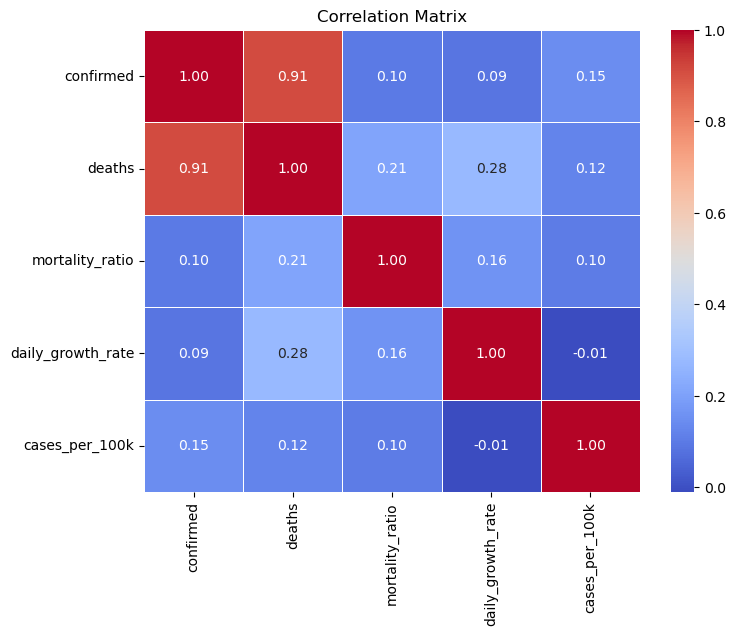

In [169]:
#Correlations between Variables Calculate the correlation matrix
corr_matrix = covid19_clean[['confirmed', 'deaths', 'ActiveCases', 'mortality_ratio', 'daily_growth_rate', 'cases_per_100k']].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of 'confirmed' and 'deaths'
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(covid19_clean['confirmed'], kde=True, color='blue')
plt.title('Distribution of Confirmed Cases')

plt.subplot(1, 2, 2)
sns.histplot(covid19_clean['deaths'], kde=True, color='red')
plt.title('Distribution of Deaths')

plt.tight_layout()
plt.show()


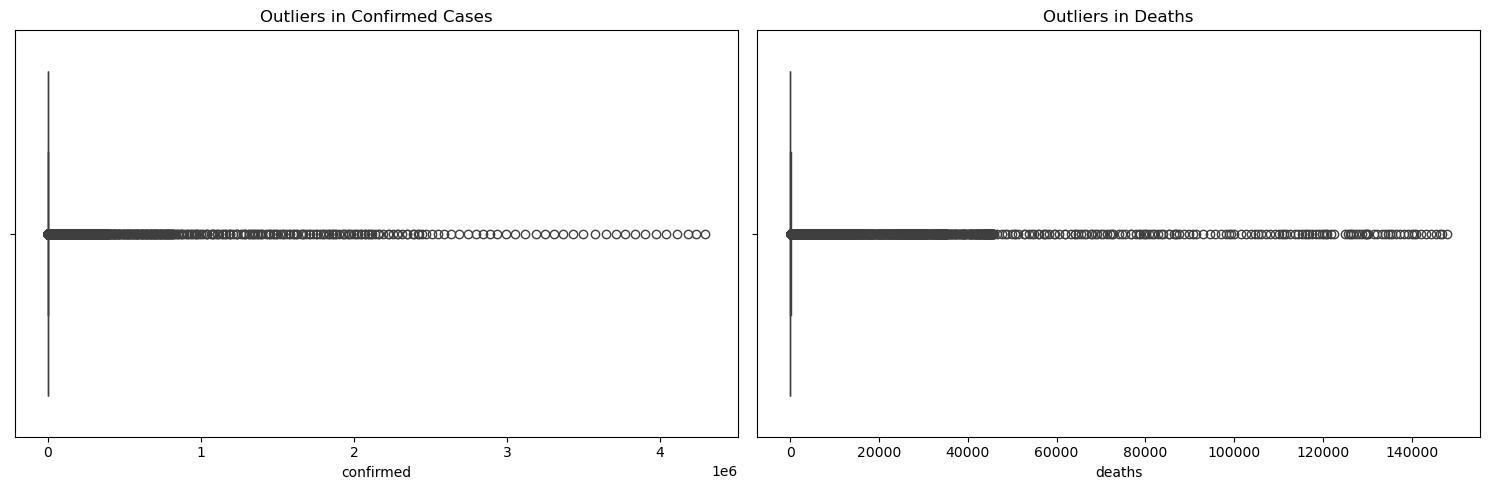

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for detecting outliers in 'confirmed' and 'deaths'
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=covid19_clean['confirmed'])
plt.title('Outliers in Confirmed Cases')

plt.subplot(1, 2, 2)
sns.boxplot(x=covid19_clean['deaths'])
plt.title('Outliers in Deaths')

plt.tight_layout()
plt.show()


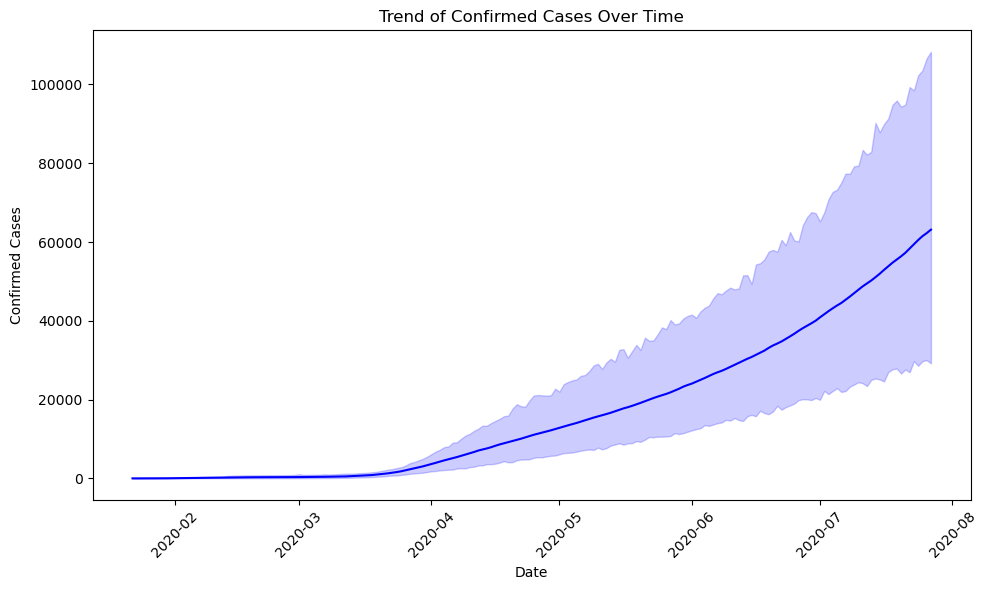

In [177]:
#Trends Over Time If there's a 'date' column, ensure it is in datetime format
covid19_clean['date'] = pd.to_datetime(covid19_clean['date'], errors='coerce')

# Plot the trend of confirmed cases over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=covid19_clean, x='date', y='confirmed', color='blue')
plt.title('Trend of Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


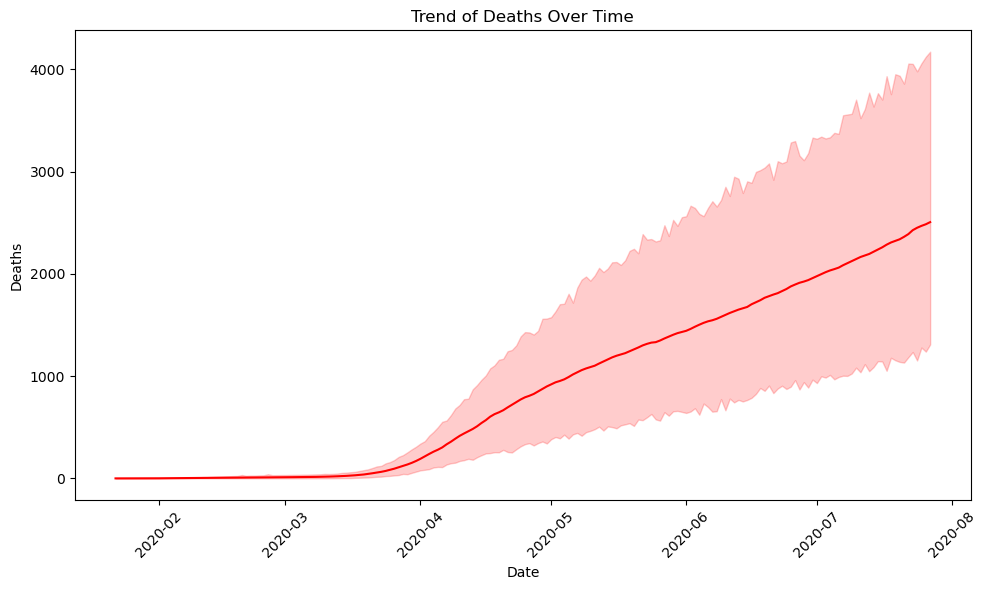

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
covid19_clean['date'] = pd.to_datetime(covid19_clean['date'], errors='coerce')

# Drop rows with missing 'date' or 'deaths' values
covid19_clean = covid19_clean.dropna(subset=['date', 'deaths'])

# Plot the trend of deaths over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=covid19_clean, x='date', y='deaths', color='red')
plt.title('Trend of Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\4279178546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_summary.head(10).index, y=country_summary.head(10)['confirmed'], palette='viridis')


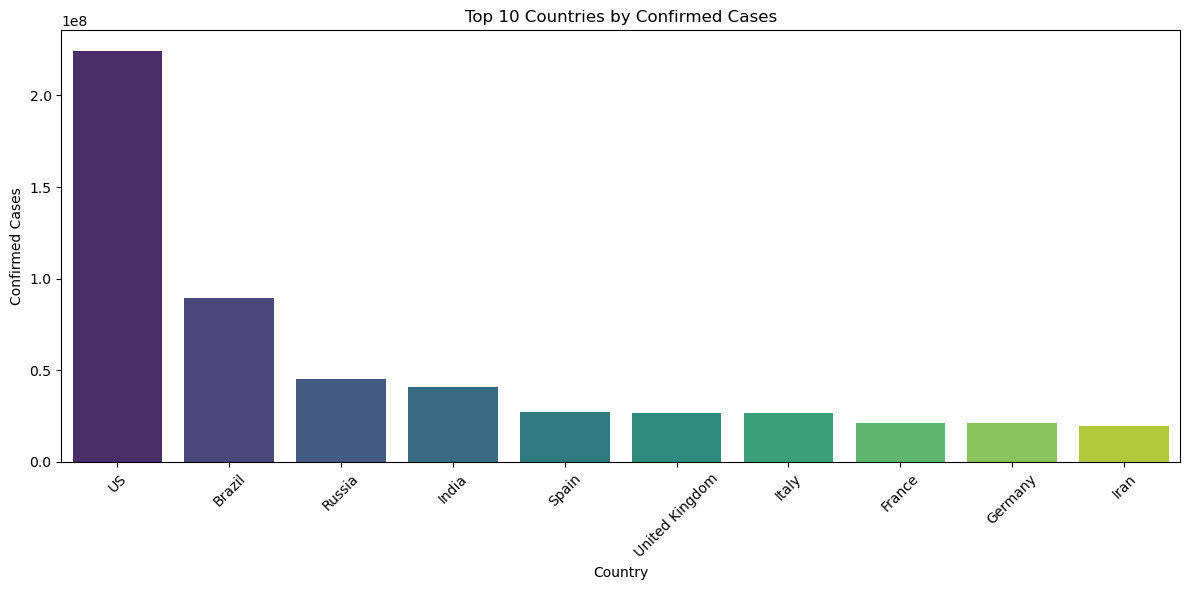

In [187]:
# Group data by 'country/region' and summarize by summing confirmed cases, deaths, and daily growth rate
country_summary = covid19_clean.groupby('country/region')[['confirmed', 'deaths', 'daily_growth_rate']].sum().sort_values(by='confirmed', ascending=False)

# Plot the top 10 countries with the highest confirmed cases
plt.figure(figsize=(12, 6))
sns.barplot(x=country_summary.head(10).index, y=country_summary.head(10)['confirmed'], palette='viridis')
plt.title('Top 10 Countries by Confirmed Cases')
plt.xlabel('Country')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_9384\1736203076.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_summary.head(10).index, y=country_summary.head(10)['deaths'], palette='viridis')


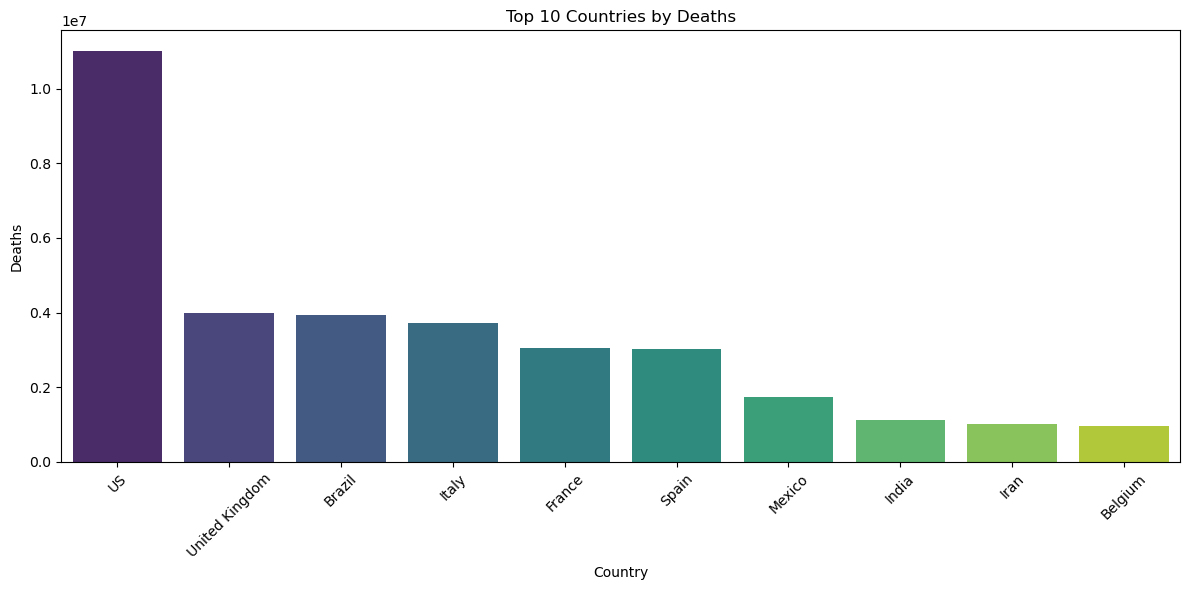

In [189]:
# Group data by 'country/region' and summarize by summing confirmed cases, deaths, and daily growth rate
country_summary = covid19_clean.groupby('country/region')[['confirmed', 'deaths', 'daily_growth_rate']].sum().sort_values(by='deaths', ascending=False)

# Plot the top 10 countries with the highest deaths
plt.figure(figsize=(12, 6))
sns.barplot(x=country_summary.head(10).index, y=country_summary.head(10)['deaths'], palette='viridis')
plt.title('Top 10 Countries by Deaths')
plt.xlabel('Country')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#ARIMA Model for Predicting Confirmed Cases Over Time
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure the 'date' column is in datetime format
covid19_clean['date'] = pd.to_datetime(covid19_clean['date'], errors='coerce')

# Group by date and sum the confirmed cases to get daily data
daily_data = covid19_clean.groupby('date')['confirmed'].sum()

# Visualize the data to understand the trend
plt.figure(figsize=(10, 6))
plt.plot(daily_data)
plt.title('Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Split the data into train and test sets
train_size = int(len(daily_data) * 0.8)  # 80% for training
train, test = daily_data[:train_size], daily_data[train_size:]

# Fit the ARIMA model
# ARIMA(p, d, q) where p = lag order, d = differencing order, q = moving average order
model = ARIMA(train, order=(5, 1, 0))  # Example: (5,1,0) - you can tune this later
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluate the model
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [195]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [197]:
# Ensure the 'date' column is in datetime format
covid19_clean['date'] = pd.to_datetime(covid19_clean['date'], errors='coerce')

# Group by date and sum the confirmed cases to get daily data
daily_data = covid19_clean.groupby('date')['confirmed'].sum()

In [199]:
# Split the data into train and test sets
train_size = int(len(daily_data) * 0.8)  # 80% for training
train, test = daily_data[:train_size], daily_data[train_size:]


In [201]:
# Fit the ARIMA model
# ARIMA(p, d, q) where p = lag order, d = differencing order, q = moving average order
model = ARIMA(train, order=(5, 1, 0))  # Example: (5,1,0) - you can tune this later
model_fit = model.fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [203]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))


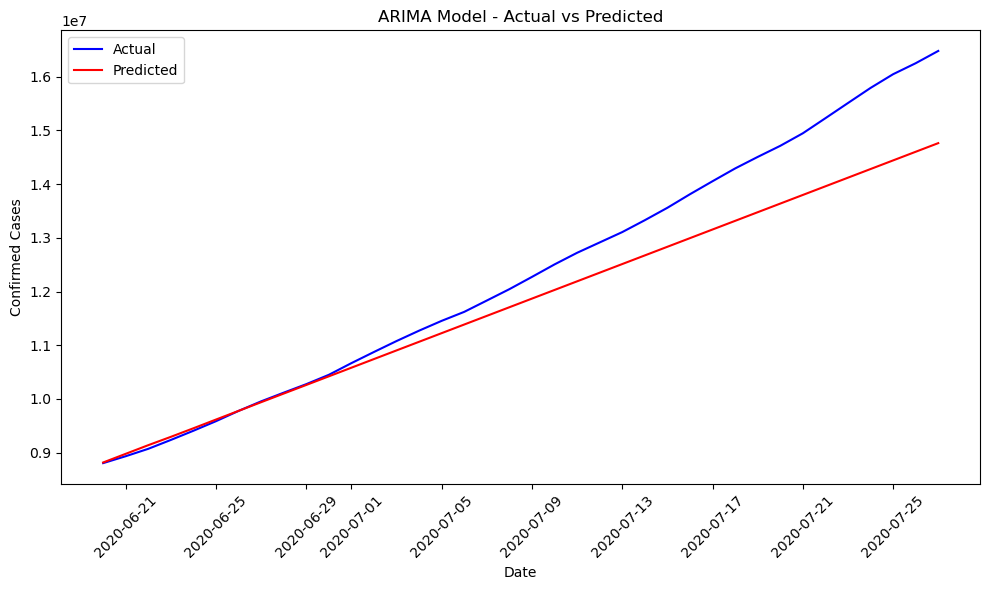

In [205]:
# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

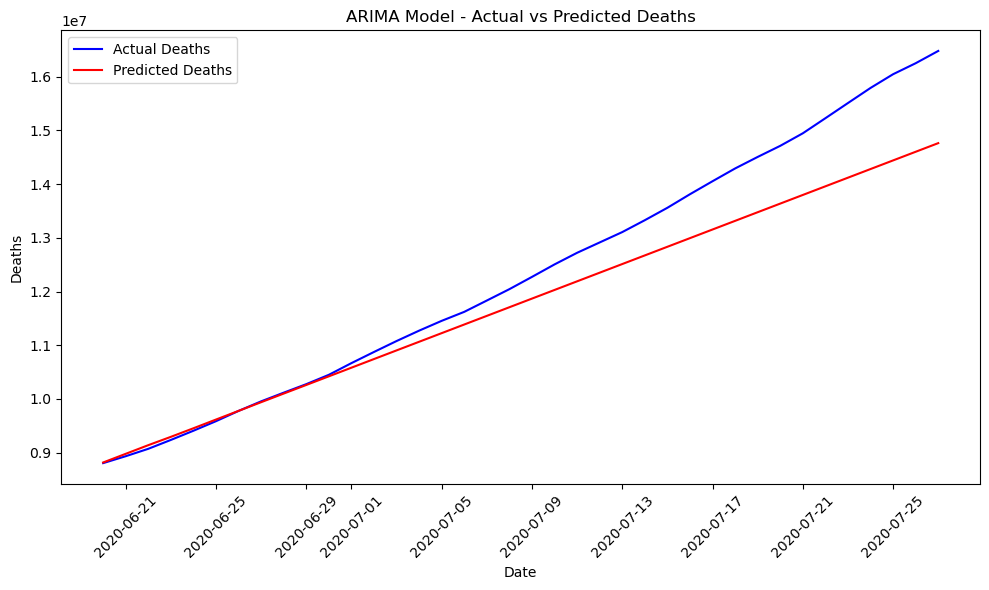

In [211]:
# Visualize the actual vs predicted values for deaths
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Deaths', color='blue')
plt.plot(test.index, predictions, label='Predicted Deaths', color='red')
plt.title('ARIMA Model - Actual vs Predicted Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [213]:
#Evaluating ARIMA model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluate the ARIMA model
mse = mean_squared_error(test, predictions)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(test, predictions)  # Mean Absolute Error

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 598507973786.9438
Root Mean Squared Error (RMSE): 773632.9709797429
Mean Absolute Error (MAE): 554124.962554484


In [215]:
from sklearn.metrics import r2_score

r2 = r2_score(test, predictions)  # R-squared Score
print(f"R² Score: {r2}")


R² Score: 0.8868642902529321
